#### Introduction: 
Wanting to start a resturant but don't know what location would be best? This is the type of data that can benefit your logic when it comes to putting down on an idea. Keep in mind that for the location you choose you may find that it does not have the traffic of the example city of Amsterdam and therefor rethink your plans. This is all good, becuase it is better to know about these things in the planning stages than down the road. This study is a form of due dilligence for anyone thinking of starting a business in an unknown territory. 

#### Data Used and why:
Stats about netherlands in general and including Ampsterdam from https://opendata.cbs.nl/#/CBS/en/
Foursquare API location data was used that contains lat and longitude as well as other info.
These two sources were used becuase they are reputable and current and encompass the scope of the ask. 



In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# creates latitude and longitude values
from geopy.geocoders import Nominatim 
from geopy.distance import geodesic

#considering transforms and requests
import requests 
from pandas.io.json import json_normalize 

# for map
import folium 

# for stats
from statistics import mean


#### Using the neighborhood data collected 

In [5]:
filename ="https://claircitydata.cbs.nl/dataset/689ded75-1a80-4259-b033-63913573c13a/resource/d02c5f12-1cfa-4d7c-91d3-41af8e4ed634/download/wijken_buurten.csv"
df_amsterdam_data=pd.read_csv(filename,delimiter=',')
df_amsterdam_data.shape

(579, 37)

In [6]:
list(df_amsterdam_data.columns)

['subject',
 'region_name',
 'regio_type',
 'region_code',
 'ninhabitants',
 'nmen',
 'nwomen',
 'nage_0_to_15',
 'nage_15_to_25',
 'nage_25_to_45',
 'nage_45_to_65',
 'nage_65_older',
 'nunmarried',
 'nmarried',
 'ndivorced',
 'nwidowed',
 'nimmigrant_western',
 'nimmigrant_nonwestern',
 'nimmigrant_marokko',
 'nimmigrant_antiles_aruba',
 'nimmigrant_surinam',
 'nimmigrant_turkey',
 'nimmigrant_other_non_western',
 'nhouseholds',
 'nhh_single_person',
 'nhh_no_children',
 'nhh_with_children',
 'ave_househ_size',
 'populatio_density',
 'area_total',
 'area_land',
 'area_water',
 'urbanisation_grade',
 'address_density',
 'geojson',
 'lon',
 'lat']

##### Looks like the info we want is in the Region type column.

In [7]:
df_amsterdam_data['regio_type'].value_counts()

Buurt       479
Wijk         99
Gemeente      1
Name: regio_type, dtype: int64

##### Now lets hone in on the specific Region where we are to potentially start a resturant "Multicultural Indische Buurt is an up-and-coming dockside area where hip eateries occupy converted industrial spaces, and late-1800s buildings house Surinamese restaurants, Moroccan supermarkets and Turkish bakeries. Flevopark, a popular picnic location overlooking Nieuwe Diep Lake, has a pond, jogging trails and a distillery bar in a former pump house, with a waterfront terrace. ― Google"

In [8]:
df_amsterdam_data=df_amsterdam_data[df_amsterdam_data['regio_type']=='Buurt']
df_amsterdam_data.shape

(479, 37)

In [9]:
df_amsterdam_data.head()

,subject,region_name,regio_type,region_code,ninhabitants,nmen,nwomen,nage_0_to_15,nage_15_to_25,nage_25_to_45,...,ave_househ_size,populatio_density,area_total,area_land,area_water,urbanisation_grade,address_density,geojson,lon,lat
2,Kop Zeedijk,Amsterdam,Buurt,BU03630000,1020,570,445,50,140,520,...,1.4,16818.0,8,6,2,1.0,6649.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.900280,52.375937
3,Oude Kerk e.o.,Amsterdam,Buurt,BU03630001,670,365,300,30,130,320,...,1.3,7615.0,9,9,0,1.0,7361.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.896156,52.373793
4,Burgwallen Oost,Amsterdam,Buurt,BU03630002,1610,880,730,120,250,755,...,1.4,25867.0,7,6,1,1.0,7544.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.898757,52.372815
5,Nes e.o.,Amsterdam,Buurt,BU03630003,370,185,180,25,70,195,...,1.4,6939.0,6,5,0,1.0,9825.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.893728,52.370861
6,BG-terrein e.o.,Amsterdam,Buurt,BU03630004,605,330,270,45,85,250,...,1.4,7157.0,10,8,2,1.0,8428.0,"{""type"": ""FeatureCollection"",""crs"": { ""type"": ...",4.895584,52.369546


In [10]:
#create a df with jsut the info that we want and exclude all else

df_amsterdam_data=df_amsterdam_data[['subject','region_name','lon','lat']]
df_amsterdam_data.head()

,subject,region_name,lon,lat
2,Kop Zeedijk,Amsterdam,4.900280,52.375937
3,Oude Kerk e.o.,Amsterdam,4.896156,52.373793
4,Burgwallen Oost,Amsterdam,4.898757,52.372815
5,Nes e.o.,Amsterdam,4.893728,52.370861
6,BG-terrein e.o.,Amsterdam,4.895584,52.369546


In [11]:
# add a column for location data for proximity data of parking and public transport
df_amsterdam_data.rename(columns={'subject': 'Neighborhood', 'region_name':'City','lon':'Longitude', 'lat':'Latitude'},inplace=True)
df_amsterdam_data['CarPark_Dist']=0
df_amsterdam_data['Close_Bus/Train']=0
df_amsterdam = df_amsterdam_data[['Neighborhood', 'City', 'Latitude','Longitude','CarPark_Dist','Close_Bus/Train']].reset_index(drop=True)
df_amsterdam.head()

,Neighborhood,City,Latitude,Longitude,CarPark_Dist,Close_Bus/Train
0,Kop Zeedijk,Amsterdam,52.375937,4.900280,0,0
1,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,0,0
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,0,0
3,Nes e.o.,Amsterdam,52.370861,4.893728,0,0
4,BG-terrein e.o.,Amsterdam,52.369546,4.895584,0,0


In [16]:
##### Now with Geopy we can link up the locations starting with Amsterdam itself
address = 'Amsterdam'
geolocator = Nominatim (user_agent="foursquare_agent")
location = geolocator.geocode(address)
ams_latitude = location.latitude
ams_longitude = location.longitude
print(f'Amsterdam location is: {ams_latitude}, {ams_longitude}')

Amsterdam location is: 52.3727598, 4.8936041


In [ ]:
##### Now to make the neighborhood map

In [23]:
map_of_amsterdam = folium.Map(location=[ams_latitude, ams_longitude], zoom_start=11)

# loop, labels and markers
for lat, lng, borough, neighborhood in zip(df_amsterdam['Latitude'], df_amsterdam['Longitude'], df_amsterdam['City'], df_amsterdam['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_of_amsterdam)  
    
map_of_amsterdam

In [24]:
##### now lets add the foursquare data of parking specifically
##### According to documentation https://developer.foursquare.com/docs/build-with-foursquare/categories/ Parking lots are listed by using this designation '4c38df4de52ce0d596b336e1'
url='https://api.foursquare.com/v2/venues/explore?&client_id=T04GVZ5Y5OXKELG2YT0ZCHRFFMWHLR5OCK0UNIOTOKC1CSDJ&client_secret=RLHN2T1IXO42MHH2CBWGHCSTCKM1T45KKXE014CVBNXX4MHH&v=20180604&ll=52.3745403,4.89797550561798&radius=3000&categoryId=4c38df4de52ce0d596b336e1&limit=100'
url

'https://api.foursquare.com/v2/venues/explore?&client_id=T04GVZ5Y5OXKELG2YT0ZCHRFFMWHLR5OCK0UNIOTOKC1CSDJ&client_secret=RLHN2T1IXO42MHH2CBWGHCSTCKM1T45KKXE014CVBNXX4MHH&v=20180604&ll=52.3745403,4.89797550561798&radius=3000&categoryId=4c38df4de52ce0d596b336e1&limit=100'

In [25]:
# using the get function, returned is JSON
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6011dc111ed4402a42c63573'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Amsterdam',
  'headerFullLocation': 'Amsterdam',
  'headerLocationGranularity': 'city',
  'query': 'parking',
  'totalResults': 100,
  'suggestedBounds': {'ne': {'lat': 52.40154032700003,
    'lng': 4.94211922411202},
   'sw': {'lat': 52.34754027299997, 'lng': 4.85383178712394}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b531b3ef964a520208f27e3',
       'name': 'Q-Park De Bijenkorf',
       'location': {'address': 'Beursstraat 15',
        'lat': 52.37413161763709,
        'lng': 4.8945793955019345,
        'labeledLatLngs': [{'label': 'display',
          'lat': 

In [30]:
# make a list of this for proximity info
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
parking = results['response']['groups'][0]['items']
    
#make JSON easier to use only show key value pairs    
df_parking = json_normalize(parking) 

# filtering
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_parking =df_parking.loc[:, filtered_columns]
df_parking['venue.categories'] = df_parking.apply(get_category_type, axis=1)

# clean 
df_parking.columns = [col.split(".")[-1] for col in df_parking.columns]
df_parking.head()

,name,categories,lat,lng
0,Q-Park De Bijenkorf,Parking,52.374132,4.894579
1,MobyPark - Parking Dam Square - Book now and p...,Parking,52.373077,4.895563
2,Q-Park De Kolk,Parking,52.376267,4.894437
3,Parkeergarage Oosterdok,Parking,52.376147,4.909100
4,ParkBee Grand Hotel Krasnapolsky,Parking,52.373005,4.895601


In [33]:
df_parking.shape [0]

97

In [34]:
df_parking.to_csv('park_amsterdam.csv')

#### Now on to Public transport, Foursquare codes to extract this info are as follows : 
Light Rail Station categoryId "4bf58dd8d48988d1fc931735",Metro Station categoryId is "4bf58dd8d48988d1fd931735"
Tram Station categoryId is "52f2ab2ebcbc57f1066b8b51",Bus Station categoryId is "4bf58dd8d48988d1fe931735" these will be used to gather the rest of the location data.

In [39]:
CLIENT_ID ='T04GVZ5Y5OXKELG2YT0ZCHRFFMWHLR5OCK0UNIOTOKC1CSDJ'
CLIENT_SECRET ='RLHN2T1IXO42MHH2CBWGHCSTCKM1T45KKXE014CVBNXX4MHH'
VERSION = '20180604'
LIMIT =100 
RADIUS =3000
ams_latitude =52.3727598
ams_longitude =4.8936041

In [40]:
category_list=['4bf58dd8d48988d1fc931735','4bf58dd8d48988d1fd931735','52f2ab2ebcbc57f1066b8b51','4bf58dd8d48988d1fe931735'] #bus/train station
c=0
df_transportationt=pd.DataFrame()

In [41]:
 # create public transport loop:

for c in range(len(category_list)):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ams_latitude, 
    ams_longitude, 
    RADIUS,
    category_list[c],
    LIMIT)
    print(url) 
    
 # Get requests    
    results = requests.get(url).json()  
    transportation = results['response']['groups'][0]['items']
    df_trans = json_normalize(transportation)  
   
 # get category of the venue
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']

        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
    
 # Clean and put into df
    
    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    df_trans =df_trans.loc[:, filtered_columns]
    df_trans['venue.categories'] = df_trans.apply(get_category_type, axis=1)
    
    # clean 
    df_trans.columns = [col.split(".")[-1] for col in df_trans.columns]

    print('Category ID {} : {}'.format(category_list[c], df_trans.shape))
    

https://api.foursquare.com/v2/venues/explore?&client_id=T04GVZ5Y5OXKELG2YT0ZCHRFFMWHLR5OCK0UNIOTOKC1CSDJ&client_secret=RLHN2T1IXO42MHH2CBWGHCSTCKM1T45KKXE014CVBNXX4MHH&v=20180604&ll=52.3727598,4.8936041&radius=3000&categoryId=4bf58dd8d48988d1fc931735&limit=100
For Category ID 4bf58dd8d48988d1fc931735 : (1, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=T04GVZ5Y5OXKELG2YT0ZCHRFFMWHLR5OCK0UNIOTOKC1CSDJ&client_secret=RLHN2T1IXO42MHH2CBWGHCSTCKM1T45KKXE014CVBNXX4MHH&v=20180604&ll=52.3727598,4.8936041&radius=3000&categoryId=4bf58dd8d48988d1fd931735&limit=100
For Category ID 4bf58dd8d48988d1fd931735 : (15, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=T04GVZ5Y5OXKELG2YT0ZCHRFFMWHLR5OCK0UNIOTOKC1CSDJ&client_secret=RLHN2T1IXO42MHH2CBWGHCSTCKM1T45KKXE014CVBNXX4MHH&v=20180604&ll=52.3727598,4.8936041&radius=3000&categoryId=52f2ab2ebcbc57f1066b8b51&limit=100
For Category ID 52f2ab2ebcbc57f1066b8b51 : (100, 4)
https://api.foursquare.com/v2/venues/explore?&client_id=T04GVZ5Y

In [43]:
# Update the dataframe
df_transportationt=df_transportationt.append(df_trans).reset_index(drop=True)

In [44]:
df_trans.head()

,name,categories,lat,lng
0,Martelaarsgracht,Bus Station,52.377654,4.896091
1,City Sightseeing Bus,Bus Station,52.377835,4.897619
2,Busstation CS Stationsplein (C en D - GVB en C...,Bus Station,52.377502,4.901842
3,Cs Ijzijde,Bus Station,52.379289,4.901442
4,Busstation Amsterdam Centraal,Bus Station,52.379927,4.900199


In [45]:
df_transportationt.shape[0]

50

In [46]:
df_trans.to_csv('transportation_in_amsterdam.csv')

#### I have three dataframes now, transportation_in_amsterdam,park_amsterdam and df_amsterdam

In [48]:
# Now we need to find the distance each neighborhood is from parking, AVG distance that is
geolocator = Nominatim(user_agent="foursquare_agent")
n=0
m=0
dist_list=[]
while True:
    if n < df_amsterdam['Neighborhood'].count():
        for m in range(df_parking['name'].count()):
            location1=list(df_amsterdam.loc[n,'Latitude':'Longitude'])
            location2=list(df_parking.loc[m,'lat':'lng'])
            dist=float('%.2f' % geodesic(location1,location2).m)
            dist_list.append(dist)
    # Update DataFrame
        df_amsterdam.loc[df_amsterdam.index[n], 'CarPark_Dist'] = ('%.2f' % mean(dist_list)) 
    # Make CarPark Dist a float    
        df_amsterdam['CarPark_Dist']=pd.to_numeric(df_amsterdam['CarPark_Dist'])
        n+=1
    else:
        print('Done')
        break

Done


In [49]:
df_amsterdam.head()

,Neighborhood,City,Latitude,Longitude,CarPark_Dist,Close_Bus/Train
0,Kop Zeedijk,Amsterdam,52.375937,4.900280,1523.99,0
1,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,1474.56,0
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1454.45,0
3,Nes e.o.,Amsterdam,52.370861,4.893728,1433.66,0
4,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1418.21,0


In [50]:
# Now we need to find the distance each neighborhood is from public transportation, AVG distance that is

geolocator = Nominatim(user_agent="foursquare_agent")
n=0
m=0
p=0
while True:
    if n < df_amsterdam['Neighborhood'].count():
        for m in range(df_transportationt['name'].count()):
            location1=list(df_amsterdam.loc[n,'Latitude':'Longitude'])
            location2=list(df_transportationt.loc[m,'lat':'lng'])
            dist=float('%.2f' % geodesic(location1,location2).m)
            if dist<=1000: 
                p+=1
#Update The Neighborhood DataFrame            
        df_amsterdam.loc[df_amsterdam.index[n], 'Close_Bus/Train'] = p 
        n+=1
        p=0
    else:
        print('Done')
        break

Done


In [51]:
df_amsterdam.head()

,Neighborhood,City,Latitude,Longitude,CarPark_Dist,Close_Bus/Train
0,Kop Zeedijk,Amsterdam,52.375937,4.900280,1523.99,33
1,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,1474.56,33
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1454.45,33
3,Nes e.o.,Amsterdam,52.370861,4.893728,1433.66,22
4,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1418.21,20


In [52]:
#compare neighborhoods 
df_amsterdam=df_amsterdam.sort_values('CarPark_Dist', ascending=True).reset_index(drop=True)
df_comparison=df_amsterdam.head(20)
df_comparison

,Neighborhood,City,Latitude,Longitude,CarPark_Dist,Close_Bus/Train
0,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1418.21,20
1,Nes e.o.,Amsterdam,52.370861,4.893728,1433.66,22
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1454.45,33
3,Stationsplein e.o.,Amsterdam,52.379658,4.900724,1467.40,32
4,Kalverdriehoek,Amsterdam,52.367917,4.891315,1473.34,5
5,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,1474.56,33
6,Begijnhofbuurt,Amsterdam,52.370704,4.891284,1480.92,10
7,Hemelrijk,Amsterdam,52.378148,4.894921,1487.63,32
8,Reguliersbuurt,Amsterdam,52.366611,4.893200,1488.68,2
9,Langestraat e.o.,Amsterdam,52.378368,4.889985,1488.70,31


In [53]:
# now to normalize data in two newest columns so we can visualize the data 
df_comparison['CarPark_Dist_N']=df_comparison['CarPark_Dist'].max()-df_comparison.CarPark_Dist
df_comparison['CarPark_Dist_N']=df_comparison['CarPark_Dist_N']/df_comparison['CarPark_Dist_N'].max()
df_comparison['Close_Bus/Train_N'] = df_comparison['Close_Bus/Train']/df_comparison['Close_Bus/Train'].max() 
df_comparison

C:\Users\Radox Babe\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Radox Babe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Radox Babe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,Neighborhood,City,Latitude,Longitude,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N
0,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1418.21,20,1.000000,0.606061
1,Nes e.o.,Amsterdam,52.370861,4.893728,1433.66,22,0.808360,0.666667
2,Burgwallen Oost,Amsterdam,52.372815,4.898757,1454.45,33,0.550484,1.000000
3,Stationsplein e.o.,Amsterdam,52.379658,4.900724,1467.40,32,0.389854,0.969697
4,Kalverdriehoek,Amsterdam,52.367917,4.891315,1473.34,5,0.316175,0.151515
5,Oude Kerk e.o.,Amsterdam,52.373793,4.896156,1474.56,33,0.301042,1.000000
6,Begijnhofbuurt,Amsterdam,52.370704,4.891284,1480.92,10,0.222153,0.303030
7,Hemelrijk,Amsterdam,52.378148,4.894921,1487.63,32,0.138923,0.969697
8,Reguliersbuurt,Amsterdam,52.366611,4.893200,1488.68,2,0.125899,0.060606
9,Langestraat e.o.,Amsterdam,52.378368,4.889985,1488.70,31,0.125651,0.939394


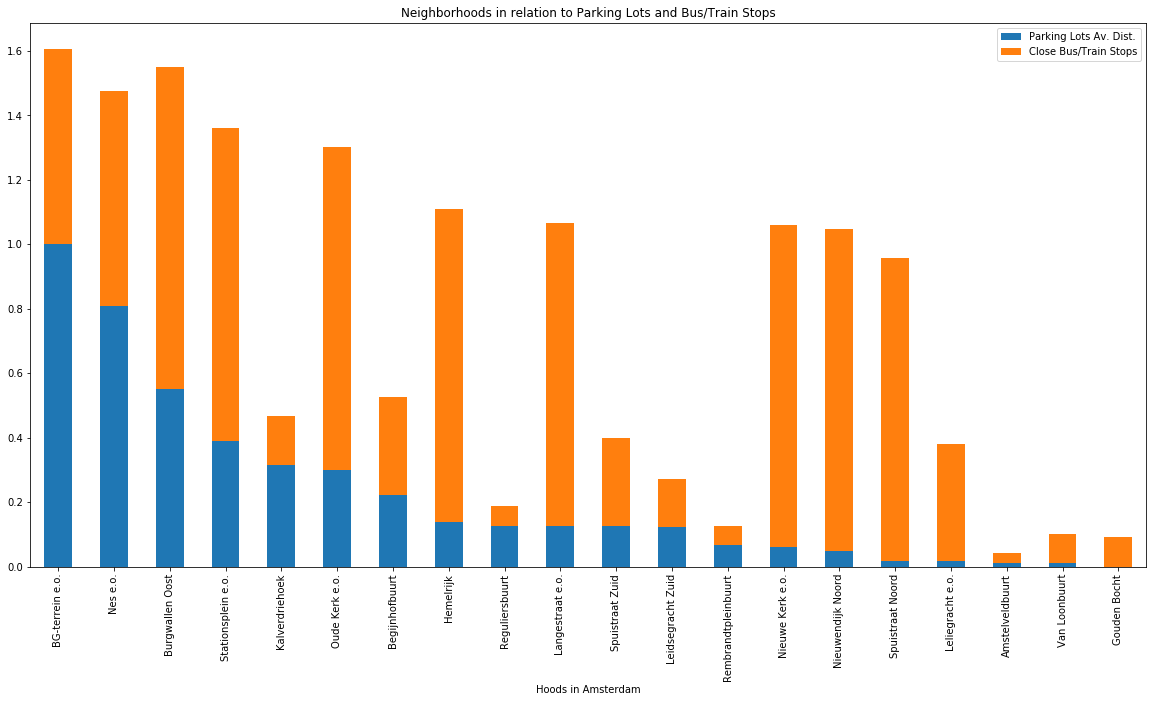

In [54]:
# create a bar chart to visualize the information 

df_comparison.plot.bar(x="Neighborhood", y=["CarPark_Dist_N", "Close_Bus/Train_N"],stacked=True,figsize=(20,10))

plt.xlabel('Hoods in Amsterdam') 

plt.title('Neighborhoods in relation to Parking Lots and Bus/Train Stops') 
plt.legend(('Parking Lots Av. Dist.', 'Close Bus/Train Stops'),loc=1)
plt.show()

In [55]:
# adding new column to sum total will give us the most accessable location
df_comparison['Total']=df_comparison['CarPark_Dist_N']+df_comparison['Close_Bus/Train_N']
df_result=(df_comparison[df_comparison['Total'] == df_comparison['Total'].max()]).reset_index(drop=True) 
df_result

C:\Users\Radox Babe\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighborhood,City,Latitude,Longitude,CarPark_Dist,Close_Bus/Train,CarPark_Dist_N,Close_Bus/Train_N,Total
0,BG-terrein e.o.,Amsterdam,52.369546,4.895584,1418.21,20,1.0,0.606061,1.606061


In [57]:
# The more detailed info on what makes this the most accessable place to start a business 
n=0
m=0
for m in range(df_parking['name'].count()):
    location1=list(df_result.loc[0,'Latitude':'Longitude'])
    location2=list(df_parking.loc[m,'lat':'lng'])
    dist=float('%.2f' % geodesic(location1,location2).m)
    if dist<500:
        n+=1
        print('Between {} and {} is {} meters'.format((df_result.loc[0,'Neighborhood']),(df_parking.at[m,'name']),dist))
    else:
        continue
print('There are {} parking lots exist in {} below 500 meters distance'.format(n,df_result.at[0,'Neighborhood']))

Between BG-terrein e.o. and MobyPark - Parking Dam Square - Book now and pay only € 3/h! is 392.96 meters
Between BG-terrein e.o. and ParkBee Grand Hotel Krasnapolsky is 384.88 meters
Between BG-terrein e.o. and Parkeergarage Geelvinck is 429.25 meters
Between BG-terrein e.o. and ParkBee is 166.59 meters
Between BG-terrein e.o. and Parking wijdesteeg is 457.57 meters
Between BG-terrein e.o. and ParkBee Kalverstraat is 406.77 meters
Between BG-terrein e.o. and De Overkant (van MdB) is 210.57 meters
Between BG-terrein e.o. and ParkBee Hotel NH City Centre Amsterdam is 455.81 meters
Between BG-terrein e.o. and Parkeergarage Stadhuis-Muziektheater is 398.65 meters
Between BG-terrein e.o. and Amstel is 303.19 meters
Between BG-terrein e.o. and Q-park Kalverpassage is 387.52 meters
Between BG-terrein e.o. and Parkking The Bank Rembrandtplein is 403.97 meters
Between BG-terrein e.o. and Fietsenstallingen Singel is 435.3 meters
Between BG-terrein e.o. and Dam is 425.3 meters
Between BG-terrein

In [59]:
# we can see this result in the folium map too

result_latitude=df_result.at[0,'Latitude']
result_longitude=df_result.at[0,'Longitude']
result_name=df_result.at[0,'Neighborhood']

result_map = folium.Map(location=[ams_latitude, ams_longitude], zoom_start=14) 


# Neighborhoods
folium.vector_layers.CircleMarker(
    [result_latitude, result_longitude],
    radius=10,
    popup=result_name,
    fill=True,
    color='yellow',
    fill_color='yellow',
    fill_opacity=0.6
    ).add_to(result_map)


# Car Park
for lat, lng, label in zip(df_parking.lat, df_parking.lng, df_parking.categories):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(result_map)
    

# Public Transport rail,train,bus
for lat, lng, label in zip(df_transportationt.lat, df_transportationt.lng, df_transportationt.categories):
    folium.vector_layers.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='green',
        fill_color='green',
        fill_opacity=0.6
        ).add_to(result_map)

# display map
result_map

### Results

BG-terrein e.o is otherwise called Centrum wich is the center of a train station area essentially. It is the most accessiable for both parking and public transport. This analysis gives us a somewhat commonsense result and that is that the transportation hubs like a huge train station will have the best transprotation and accessibility routes. However it might not have the best environment for a sit down resturant. Hence we may be inclined to find an area that is more suitable with the same or reletivly same traffic.
So we could in turn pick the second best location as indicated by the large quantity of parking and transport locations know as the NES. (https://en.wikipedia.org/wiki/Nes_(Amsterdam). This seems a more fitting location for a new resturant as it is a bit less of a train depot.:-)




### Discussion

There are many other factors we could have introduced to further refine the search including demographics, proximity to art venues, other resturants of similar flavor. THese things are good to consider too but we would need more specific information on the resturant owners plans in order to investigate further. On the whole this gives us a clear outline of which areas are most accessable by both private (car) and public (Train/bus) transport systems. 

Also a cultural consideration to look at is that native people to this area use bike and canals for tranport on a regualr basis and positioning a cafe by a popular bike route could be equally so or even more benificial than making determinations based on automobile acccesibility. 

In turn if the goal of the business was to have year round traffic and popularity it would be essential to consider both local and tourist traffic patterns. According to https://www.frommers.com/ ""In season" in Amsterdam means mid-April to mid-October. The tourist season peaks in July and August, when the weather's at its finest. Climate, however, is never really extreme at any time of year; if you favor off-season travel, you'll find the city every bit as attractive during these months." That is a total of 6 months of the year that is technically tourist season. 

For the other 6 months of the year a business wants to thrive as well.This might even lend itself to a mixed fusion restruant concept that changes with the seasons. Similar to the iconic https://www.tripadvisor.com/Restaurant_Review-g60878-d433194-Reviews-Coastal_Kitchen-Seattle_Washington.html in Seattle and so many inovative food spots. 




#### Conculsion

While the existing analysis has its limits it achieves its goal of discovering the areas that are most accessable to both private and public transport. Now to explore what type of cuisine would be best! 

#### Presentation Link
https://b35f2086-1e6f-4679-86e7-1071cd731a26.filesusr.com/ugd/143bec_dffbc2e0c19b4328aa46f8cd70fc0b59.pdf